In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from AnalyseDefects import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

In [2]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 0, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

In [3]:
system_size_list = [256, 512, 1024, 2048]
Nscale = True



In [ ]:
# deff arrs: dens, dens norm [per frame + tot], 
# order ps: clean, shifted by mean, area 
# sus via dens fluc or 2 kinds of var
# full vs tav
N = 2

def_arr, _, dens_fluc_full, av_counts = ad.get_arrays_full(Ndataset = N)
av_def = ad.get_arrays_av(Ndataset = N)[-1]
def_arr_av = ad.get_arrays_av(Ndataset = N)[0]
dens_fluc = dens_fluc_full * (def_arr[:, None, :, :] / LL ** 2) ** 2

act_list = ad.act_list[N]
conv_list = ad.conv_list[N]

#conv_list = [1100] * len(conv_list)

def_arr /= LL ** 2
def_arr_av /= LL ** 2
av_def /= LL ** 2

def_arr_normf = def_arr / def_arr_av [:, :, None]
def_arr_normt = def_arr / av_def[:,0][None, :, None]

#def_arr_shiftf = (def_arr - def_arr_av[:, :, None]) / def_arr_av [:, :, None]
#def_arr_shiftt = (def_arr - av_def[:,0][None, :, None]) / av_def[:,0][None, :, None]

dens_fluc = dens_fluc /  av_def[:,0][None, None, :, None] ** 2
av_counts = av_counts / LL ** 2
av_counts = av_counts #/ av_def[:,0][None, None, :, None]

wmin = 0
fmin = 0
sus_ft = np.nanmean(dens_fluc[fmin:,wmin:,:,:], axis = (0, 1, -1))
sus_ft *= av_def[:,0][:] * LL ** 2
binder_ft = np.nanmean(av_counts[fmin:,wmin:,:,:], axis = (0, 1, -1)) ** 4 \
            / np.nanmean(av_counts[fmin:,wmin:,:,:] ** 2, axis = (0, 1, -1)) ** 2 

binder_ft = 1 - binder_ft/3

A = np.pi * 1.25 ** 2
scaling = 1
rho_max = 0.01
Nmax = rho_max * LL ** 2
def_arr_a = (scaling * 2  * A * def_arr * LL ** 2 - LL ** 2) / (LL ** 2)
def_arr_n = (2 * def_arr * LL ** 2 - Nmax) / (Nmax)
def_arr_rho = (scaling * 2  * def_arr - rho_max) / (rho_max)

In [23]:


def analyse_sus_binder(Nscale, system_size_list, order_param_func, Npower = 1, shift = False, normalize_sus = True):

    for i, LL in enumerate(system_size_list):
        output_path = f'data\\nematic_analysis{LL}_LL0.05'
        mode = 'all' # 'all' or 'short'
        defect_list = gen_analysis_dict(LL, mode)
        ad = AnalyseDefects(defect_list, output_path=output_path)

        for N in range(ad.Ndata):
            av_defects = ad.get_arrays_av(Ndataset = N)[-1]
            def_arr = ad.get_arrays_full(Ndataset = N)[0]
            order_param = order_param_func(def_arr, av_defects, LX = LL, shift = shift)
   
            ad.calc_sus_binder(order_param = order_param, Ndataset = N, Nscale=Nscale, Npower = Npower, save = True)

        ad.merge_results()

    ada = AnalyseDefectsAll(system_size_list)
    binder, sus = ada.get_binder_susceptibility(LL)

    fig, ax = plt.subplots(2, 2, figsize = (16, 12))
    ax = ax.flatten()

    for N, act_list in enumerate(ada.act_list):
        binder, sus = ada.get_binder_susceptibility(ada.LX[N])

        act_max = 0.022
        act_max_idx = act_list.index(act_max)

        ax[2].plot([ada.LX[N]], sus[act_max_idx], label = f'act = {act_list[act_max_idx]}', marker = 'o', color = f'C{N}')
        if normalize_sus:    
            sus = sus / sus[act_max_idx].max()
            

        reduced_act = (np.array(act_list) - act_max) / act_max
        reduced_act *= system_size_list[N] ** 2

        ax[0].plot(act_list, sus, label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}')
        ax[1].plot(act_list, binder, label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}')


        ax[3].plot(reduced_act, sus, label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}')

        

    ax[0].set_xlabel('Activity')
    ax[0].set_ylabel('Susceptibility')
    ax[0].set_title('Susceptibility v Activity')
    ax[0].legend(fontsize=10)

    ax[1].set_xlabel('Activity')
    ax[1].set_ylabel('Binder Cumulant')
    ax[1].set_title('Binder Cumulant')
    ax[1].legend(fontsize=10)

    ax[2].set_xlabel('System Size')
    ax[2].set_ylabel('Susceptibility')
    ax[2].set_title('Susceptibility v System Size')
    ax[2].legend(fontsize=10)

    ax[3].set_xlabel(rf'$\zeta_r L ^2$')
    ax[3].set_ylabel('Susceptibility')
    ax[3].set_title('Susceptibility v Reduced Activity')
    ax[3].legend(fontsize=10)

    return fig, ax

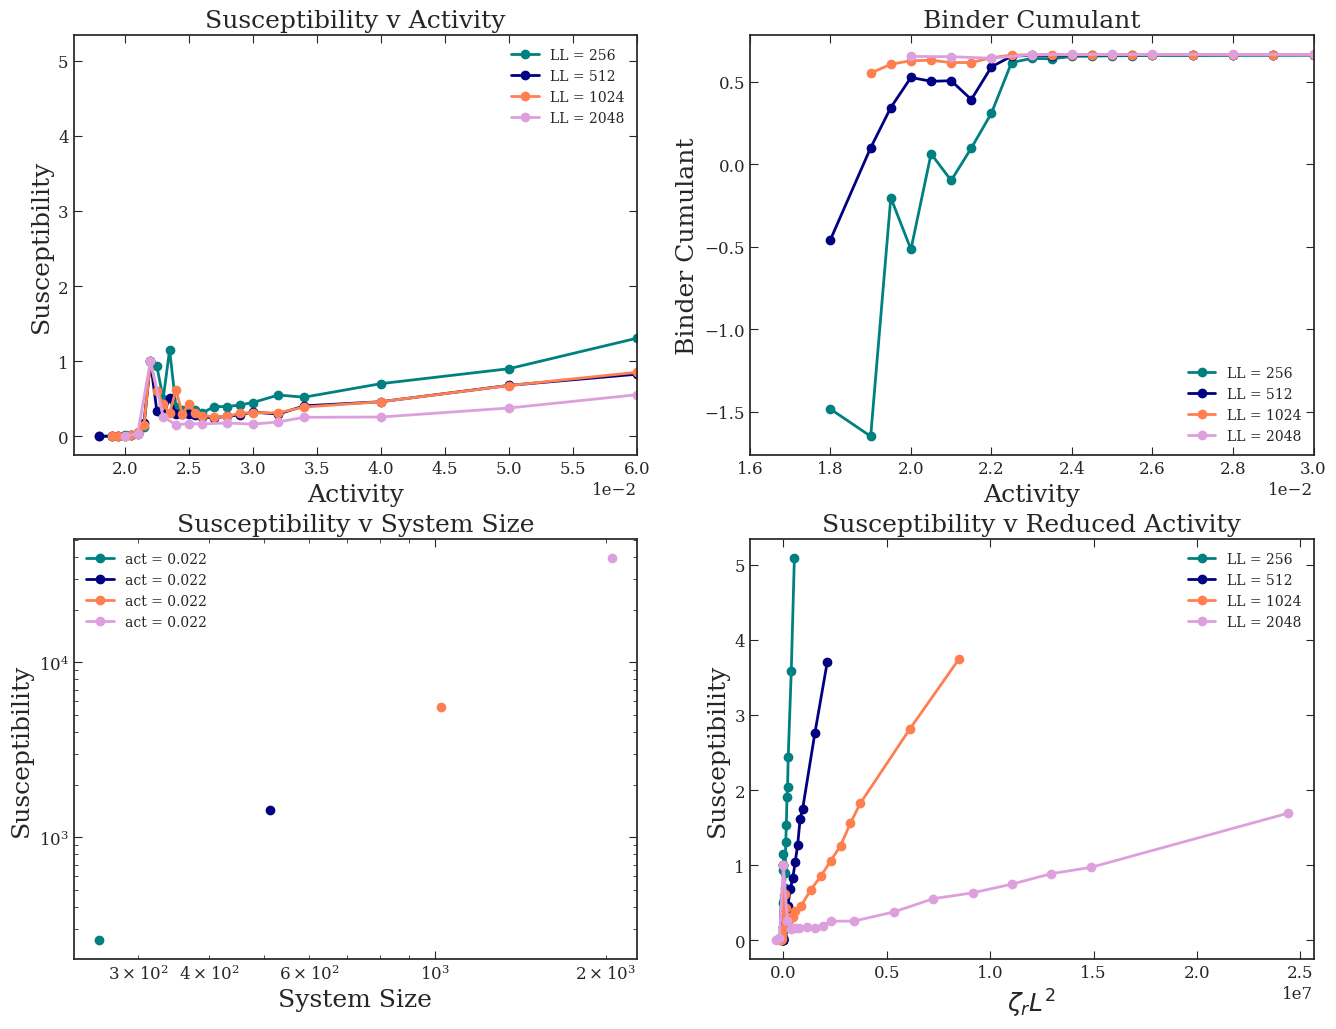

In [11]:
def order_param_func(def_arr, av_defects, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = False, system_size_list = system_size_list, order_param_func = order_param_func, shift = False, normalize_sus = True)

ax[0].set_xlim(0.016, 0.06)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')


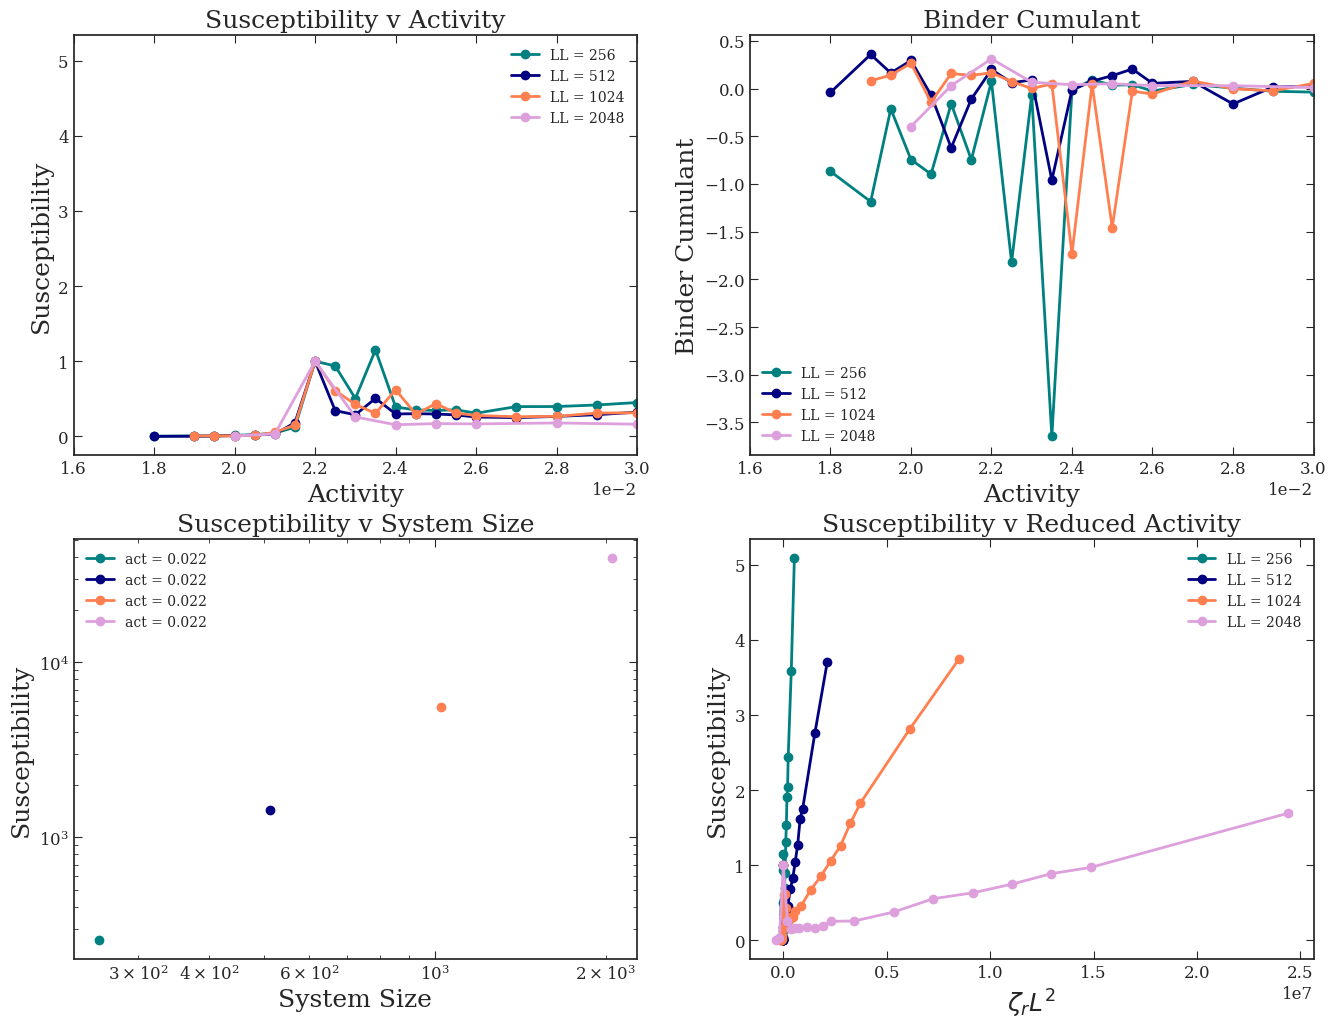

In [12]:
Nscale = False
shift = True

def order_param_func(def_arr, av_defects, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list, order_param_func = order_param_func, shift = shift, normalize_sus = True)

ax[0].set_xlim(0.016, 0.03)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')


(-1000000.0, 1000000.0)

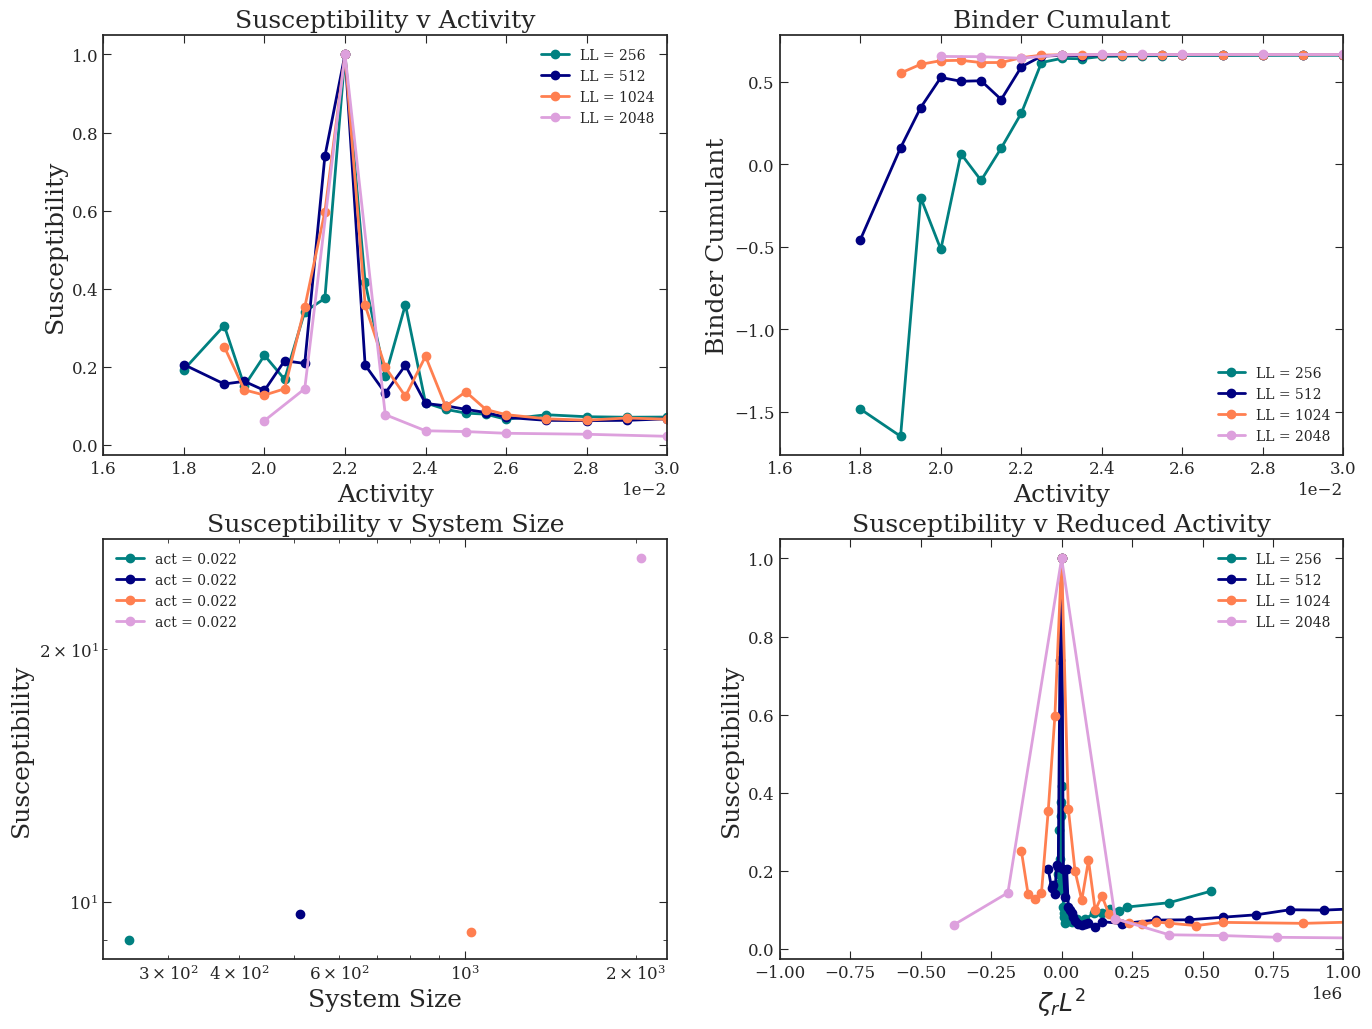

In [19]:
Nscale = True
shift = False
Npower = 1

def order_param_func(def_arr, av_defects, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    order_param /= av_defects[:,0][None, :, None]
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list, \
                              order_param_func = order_param_func, shift = shift, Npower = Npower, normalize_sus = True)

ax[0].set_xlim(0.016, 0.03)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xlim(-1e6, 1e6)


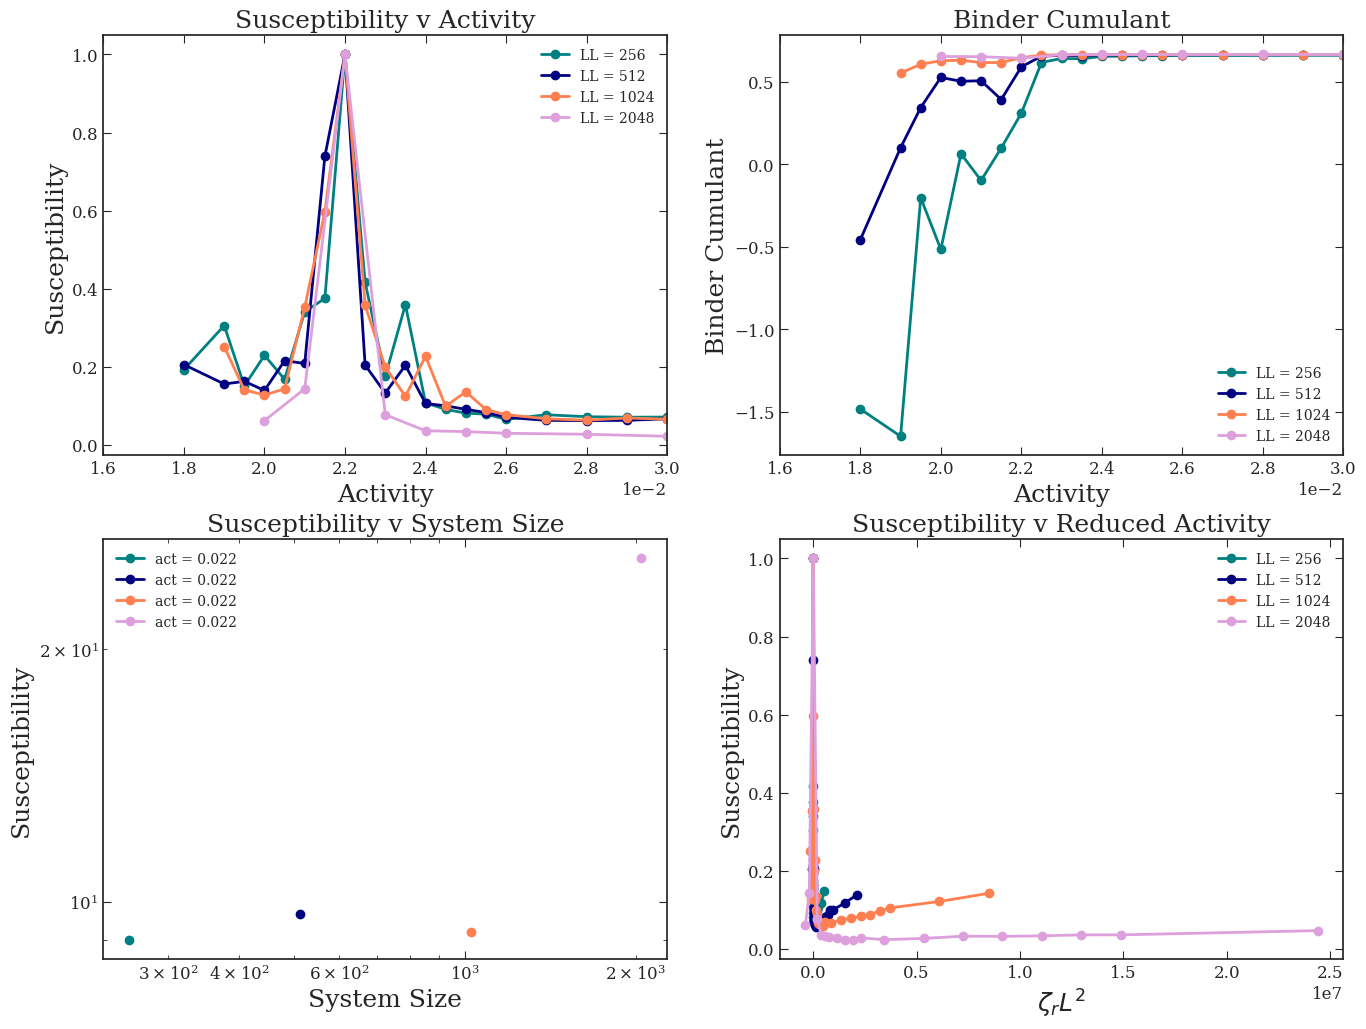

In [26]:
Nscale = True
shift = False
Npower = 1

def order_param_func(def_arr, av_defects, LX, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    order_param /= av_defects[:,0][None, :, None]
   # order_param *= LX
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list, \
                            order_param_func = order_param_func, Npower = Npower, shift = shift, normalize_sus = True)

ax[0].set_xlim(0.016, 0.03)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')


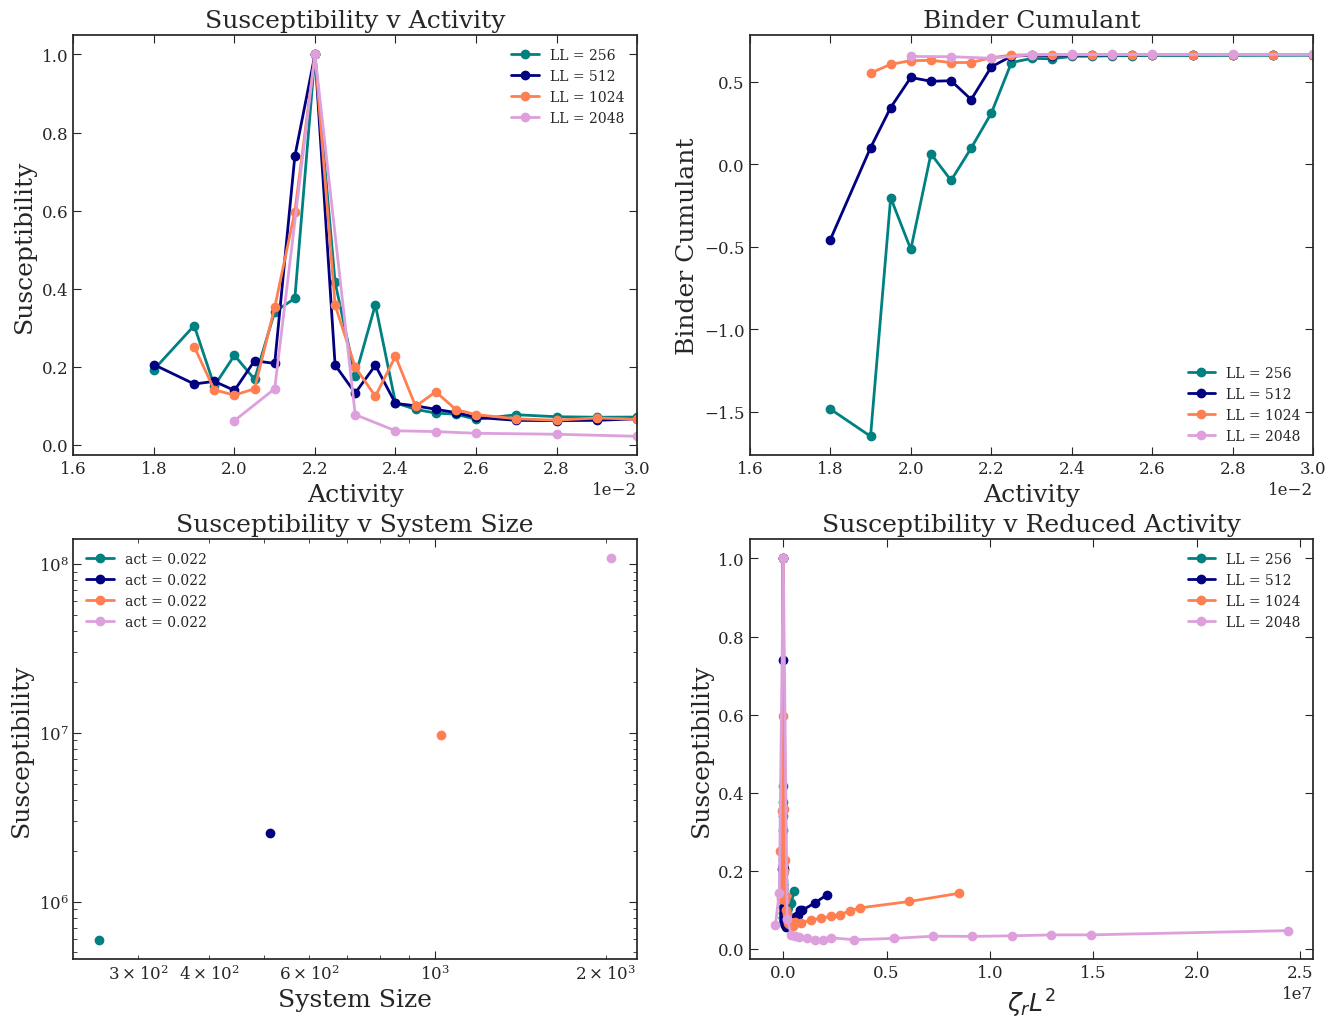

In [25]:
Nscale = True
shift = False
Npower = 1

def order_param_func(def_arr, av_defects, LX, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    order_param /= av_defects[:,0][None, :, None]
    order_param *= LX
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list, \
                            order_param_func = order_param_func, Npower = Npower, shift = shift, normalize_sus = True)

ax[0].set_xlim(0.016, 0.03)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')


In [28]:
A = np.pi * 1.25 ** 2
scaling = 1
rho_max = 0.01
#Nmax = rho_max * LL ** 2
#def_arr_a = (scaling * 2  * A * def_arr * LL ** 2 - LL ** 2) / (LL ** 2)
#def_arr_n = (2 * def_arr * LL ** 2 - Nmax) / (Nmax)
#def_arr_rho = (scaling * 2  * def_arr - rho_max) / (rho_max)

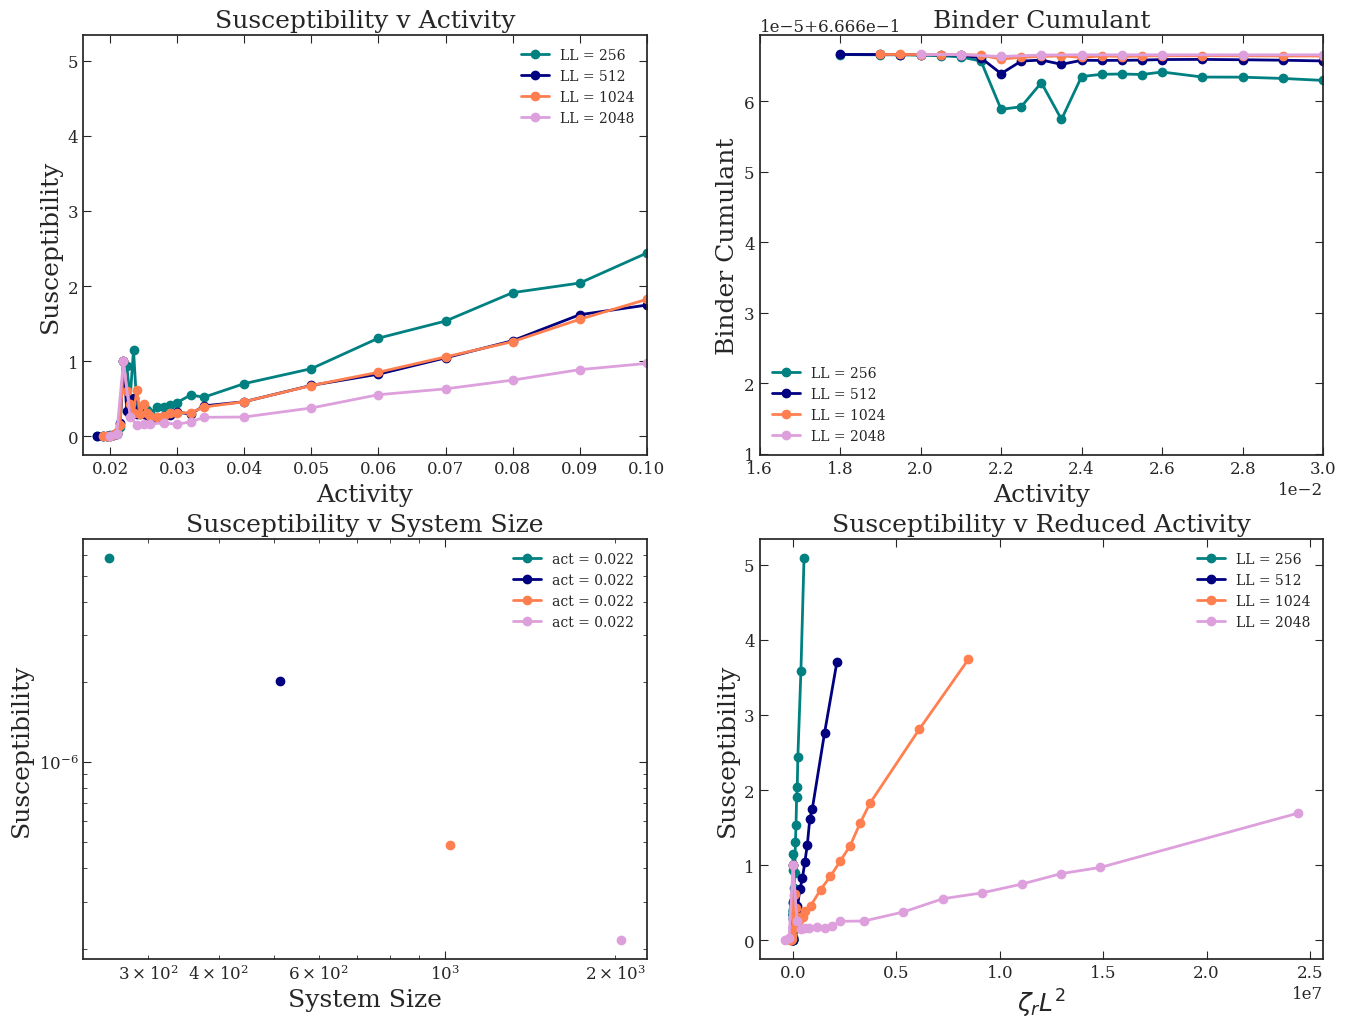

In [35]:
Nscale = False
shift = False
Npower = 1

def order_param_func(def_arr, av_defects, LX, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

   # order_param /= av_defects[:,0][None, :, None]
   # order_param *= LX
    order_param = (2  * A * def_arr - LX ** 2) / LX ** 2
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list, \
                            order_param_func = order_param_func, Npower = Npower, shift = shift, normalize_sus = True)

ax[0].set_xlim(0.016, 0.1)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')